# OrNV Transmission Experiment

This notebook generates figures which are used by **ornv-transmission.tex** to generate a nicely formated PDF report.

Please use **Python3 (py3env)** kernel.
[Click here for more info.](
https://github.com/aubreymoore/wiki/wiki/Installing-Jupyter-and-Using-Jupyter-Notebooks-on-Ubuntu-18.04)

If you need to install an additional python package,
do something like this:
```
import sys
!{sys.executable} -m pip install matplotlib
```

In [127]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
from lifelines import KaplanMeierFitter, statistics
import numpy as np
import re
import subprocess

In [128]:
# Create a dataframe from data stored in ornv-transmission-1.csv

df = pd.read_csv('ornv-transmission-1.csv', parse_dates=[3,4])

In [129]:
# Create some extra columns
# t is time until death in days after start of bioassay
# e is a boolean indication that the beetle died during the bioassay

df['date_end_bioassay'] = df.date_died.max()
t, e = lifelines.utils.datetimes_to_durations(
    start_times=pd.to_datetime(df.date_treated),
    end_times=pd.to_datetime(df.date_died),
    fill_date=pd.to_datetime(df.date_end_bioassay))
df['t'] = t
df['e'] = e
df

,jar_id,sex,treatment,date_treated,date_died,postmortem_virus,postmortem_bacteria,pm_image_filename,date_end_bioassay,t,e
0,C1,m,none,2019-12-26,2020-01-16,NaN,NaN,20200116_110145_001.jpg,2020-02-06,21.0,True
1,C2,m,none,2019-12-26,2020-01-29,NaN,NaN,20200129_145244.jpg,2020-02-06,34.0,True
2,C3,m,none,2019-12-26,2020-01-19,NaN,NaN,20200119_121343.jpg,2020-02-06,24.0,True
3,C4,m,none,2019-12-26,2020-01-21,NaN,NaN,20200121_112302.jpg,2020-02-06,26.0,True
4,C5,m,none,2019-12-26,2020-01-29,NaN,NaN,NaN,2020-02-06,34.0,True
5,C6,m,none,2019-12-27,NaT,NaN,NaN,20200210_150730.jpg,2020-02-06,41.0,False
6,C7,m,none,2019-12-27,2020-01-02,NaN,NaN,20200102_112827.jpg,2020-02-06,6.0,True
7,C8,m,none,2019-12-27,2020-01-23,NaN,1.0,20200123_163747.jpg,2020-02-06,27.0,True
8,C9,m,none,2019-12-27,2020-01-25,NaN,NaN,NaN,2020-02-06,29.0,True
9,C10,m,none,2019-12-27,NaT,NaN,NaN,NaN,2020-02-06,41.0,False


<IPython.core.display.Javascript object>


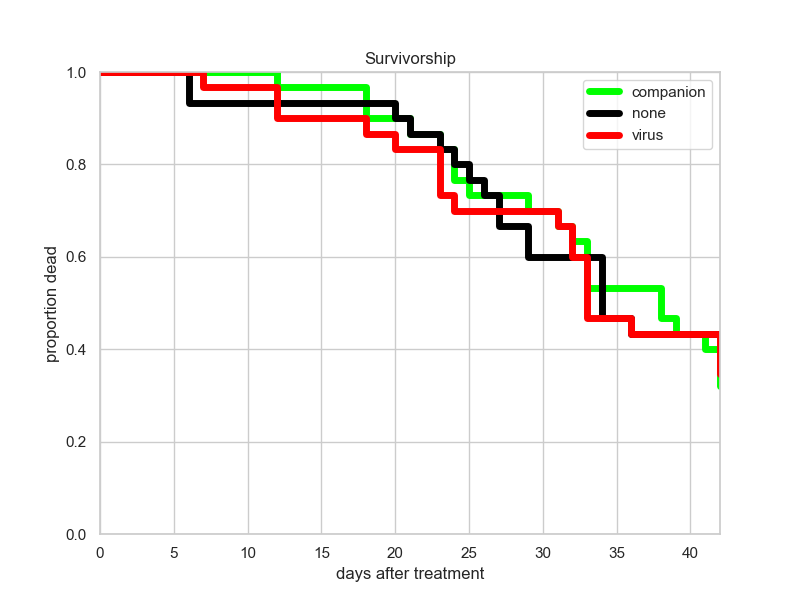

In [130]:
# Generate a survivorship plot.

sns.set()
sns.set_style("whitegrid")

# Create custom palette
colors = ["#00FF00", "#000000","#FF0000", ]
sns.set_palette(sns.color_palette(colors))

# Create survorship plot

fig, ax = plt.subplots(figsize=(8,6))
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby('treatment'):
    kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
    kmf.plot(ax=ax, linewidth=5, ci_show=False)
ax.set_xlabel('days after treatment')
ax.set_ylabel('proportion dead')
ax.set_ylim([0,1])
ax.set_title('Survivorship');
fig.savefig('survivorship.pdf')

In [131]:
def plot_pairs(tgroup, plot_title):
    """
    Generate a plot showing dates on which partneres were found dead.
    
    tgroup: 'TF' or 'TM'
    plot_title: 'Females dosed with virus' for example
    """
    # Copy the slice where jar_id starts with 'TF'
    dftf = df[df.jar_id.str.startswith(tgroup)].copy()

    # Filter out beetles which did not die
    dftf = dftf[dftf.e]

    # Create 'pair_id' column
    dftf['pair_id'] = dftf.apply(lambda row: int(re.findall('\d+',row.jar_id)[0]), axis=1)

    # Sort so that virus treatments come first
    dftf.sort_values(by='treatment', inplace=True, ascending=False)

    sns.set()
    sns.set_style("whitegrid")

    # Create custom palette
    colors = ["#FF0000", "#00FF00"]
    sns.set_palette(sns.color_palette(colors))

    p = sns.lmplot(x='t', y='pair_id', data=dftf, hue='treatment', fit_reg=False, y_jitter=0.2)
    p = p.set(xlim=(0,43))
    p = p.set(ylim=(0,16))
    p = p.set(yticks=np.arange(1,16,1))
    p = p.set(xticks=np.arange(0,43,4))
    plt.title(plot_title)
    return p

#p = plot_pairs('TF', 'Females dosed with virus')
#p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


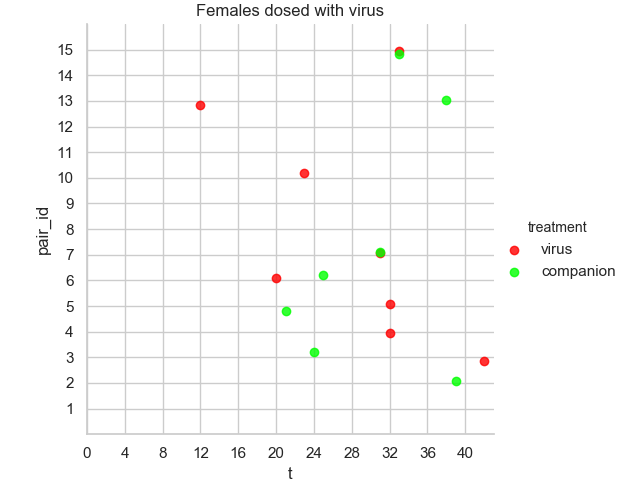

In [132]:
p = plot_pairs('TF', 'Females dosed with virus')
p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


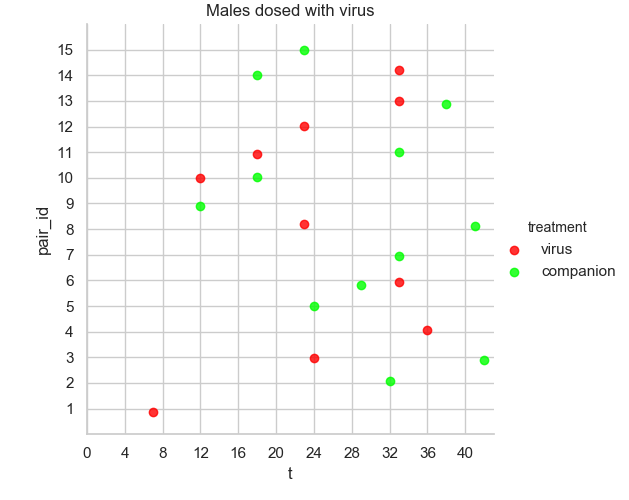

In [133]:
p = plot_pairs('TM', 'Males dosed with virus')
p.savefig('tm.pdf')

In [134]:
# Get number of jars in which 0, 1, or 2 beetles died.
g = df.groupby('jar_id')['e'].sum()
np.unique(g, return_counts=True)

(array([0., 1., 2.]), array([ 9, 18, 18]))

In [135]:
df

,jar_id,sex,treatment,date_treated,date_died,postmortem_virus,postmortem_bacteria,pm_image_filename,date_end_bioassay,t,e
0,C1,m,none,2019-12-26,2020-01-16,NaN,NaN,20200116_110145_001.jpg,2020-02-06,21.0,True
1,C2,m,none,2019-12-26,2020-01-29,NaN,NaN,20200129_145244.jpg,2020-02-06,34.0,True
2,C3,m,none,2019-12-26,2020-01-19,NaN,NaN,20200119_121343.jpg,2020-02-06,24.0,True
3,C4,m,none,2019-12-26,2020-01-21,NaN,NaN,20200121_112302.jpg,2020-02-06,26.0,True
4,C5,m,none,2019-12-26,2020-01-29,NaN,NaN,NaN,2020-02-06,34.0,True
5,C6,m,none,2019-12-27,NaT,NaN,NaN,20200210_150730.jpg,2020-02-06,41.0,False
6,C7,m,none,2019-12-27,2020-01-02,NaN,NaN,20200102_112827.jpg,2020-02-06,6.0,True
7,C8,m,none,2019-12-27,2020-01-23,NaN,1.0,20200123_163747.jpg,2020-02-06,27.0,True
8,C9,m,none,2019-12-27,2020-01-25,NaN,NaN,NaN,2020-02-06,29.0,True
9,C10,m,none,2019-12-27,NaT,NaN,NaN,NaN,2020-02-06,41.0,False


## Post mortem images section

In [136]:
dftemp = df[df.pm_image_filename.notnull()]

template = r"""
\begin{figure}[h!]
\centering
\includegraphics[width=\textwidth]{<<filename>>}
\caption{<<caption>>}
\end{figure}
\clearpage
"""

s = ''
for i, r in dftemp.iterrows():
    filename = 'pm-images/{}'.format(r.pm_image_filename)
    caption = '\\textbf{{{}{}}} '.format(r.jar_id, r.sex)
    caption += str(r).replace('_', '\_')
    s += template.replace('<<filename>>', filename).replace('<<caption>>', caption)
print(s)        
with open("pm-images.tex", "w") as f: 
    f.write(s) 


\begin{figure}[h!]
\centering
\includegraphics[width=\textwidth]{pm-images/20200116_110145_001.jpg}
\caption{\textbf{C1m} jar\_id                                      C1
sex                                          m
treatment                                 none
date\_treated               2019-12-26 00:00:00
date\_died                  2020-01-16 00:00:00
postmortem\_virus                           NaN
postmortem\_bacteria                        NaN
pm\_image\_filename      20200116\_110145\_001.jpg
date\_end\_bioassay          2020-02-06 00:00:00
t                                           21
e                                         True
Name: 0, dtype: object}
\end{figure}
\clearpage

\begin{figure}[h!]
\centering
\includegraphics[width=\textwidth]{pm-images/20200129_145244.jpg}
\caption{\textbf{C2m} jar\_id                                  C2
sex                                      m
treatment                             none
date\_treated           2019-12-26 00:00:00
date\_di

In [137]:
'\textbf{{{}{}}}'.format(r.jar_id, r.sex)

'\textbf{TM15f}'

## Generate report.

In [138]:
# Convert the *.tex file to a PDF. Assumes a TEX package is installed.
subprocess.call(['pdflatex', 'ornv-transmission.tex'])

0

In [139]:
# View the PDF using the default PDF viewer.
subprocess.call(['xdg-open', 'ornv-transmission.pdf'])

0